# Segmentez des clients d'un site e-commerce - *Notebook essais*

In [2]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn import datasets
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import timeit
import warnings

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


## Elaborer un modèle de clustering

Chargeons le dataset généré lors de l'exploration

In [4]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_5/data_projet/cleaned/data_olist_cleaned.csv", sep=',', low_memory=False)
data.head()

,latitude,longitude,nb_jours_anciennete,recence,frequence,montant,nb_jours_entre_chaque_commande,score_moyen,nb_notes
0,-23.606033,-46.637242,519,-2.365248,5.199338,2.083949,30.573540,4.764706,17.0
1,-24.000695,-46.394515,393,-0.236799,5.199338,2.359068,28.138743,2.777778,9.0
2,-18.946711,-49.451508,338,-0.143512,5.199338,2.174590,37.559075,5.000000,7.0
3,-23.948291,-46.325421,393,-1.102440,5.199338,2.022140,43.742868,5.000000,7.0
4,-8.121023,-34.896307,373,-0.873515,5.199338,2.173204,31.100443,5.000000,7.0


In [5]:
data.shape

(96096, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        95828 non-null  float64
 1   longitude                       95828 non-null  float64
 2   nb_jours_anciennete             96096 non-null  int64  
 3   recence                         96096 non-null  float64
 4   frequence                       96096 non-null  float64
 5   montant                         96096 non-null  float64
 6   nb_jours_entre_chaque_commande  96096 non-null  float64
 7   score_moyen                     96096 non-null  float64
 8   nb_notes                        96096 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 6.6 MB


### 1 - essai n°1 - features RFM avec K-means

Il s'agit ici d'utilser les 3 features RFM (recence, frequence et montant) pour un premier clustering avec l'algorithme k-means.

#### 1.1 - Filtrage des 3 features

In [8]:
X_1 = data[['recence', 'frequence', 'montant']].copy()
X_1.shape

(96096, 3)

In [9]:
X_1.describe()

,recence,frequence,montant
count,96096.000000,96096.000000,96096.000000
mean,-0.005261,-4.969655,-0.009231
std,1.007897,1.281230,1.002558
min,-5.199338,-5.199338,-5.199338
25%,-0.689529,-5.199338,-0.689847
50%,-0.011291,-5.199338,0.002509
75%,0.689529,-5.199338,0.657615
max,5.199338,5.199338,5.199338


#### 1.2 - Test k-means

In [11]:
warnings.filterwarnings("ignore")

# Une liste vide pour enregistrer les inerties :  
inertia_list = [ ]
silhouette_avg_list = []

# Notre liste de nombres de clusters : 
k_list = range(2, 8)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++")
    
    # On entraine
    labels = kmeans.fit_predict(X_1)
    
    # On enregistre l'inertie obtenue : 
    inertia_list.append(kmeans.inertia_)
    
    # Calculer le coefficient de silhouette global
    silhouette_avg = silhouette_score(X_1, labels)
    silhouette_avg_list.append(round(silhouette_avg, 2))
    
    # Calculer les coefficients de silhouette pour chaque point
    #silhouette_values = silhouette_samples(X_1, labels)

In [12]:
inertia_list

[192460.30882492953,
 132049.9710761452,
 91658.80785680849,
 73520.81494709275,
 63397.93352002368,
 53402.96333808854]

In [13]:
silhouette_avg_list

[0.77, 0.32, 0.34, 0.33, 0.31, 0.33]

Le coefficient de silhouette prend en compte non seulement la densité des clusters mais aussi l'écart entre les différents clusters.

On voit que le coefficient de silhouette (0,75 proche de 1) est le meilleur pour 2 clusters. Cela signifie que la densité des clusters est bonne et que l'écart est respecté.

On voit ensuite que le coefficient de silhouette décline fortement, au-delà de 2 pour les valeurs de k = 3, 4, 5, et 6. Comme on le verra par la suite, c'est parceque l'écart entre certains clusters est faible.

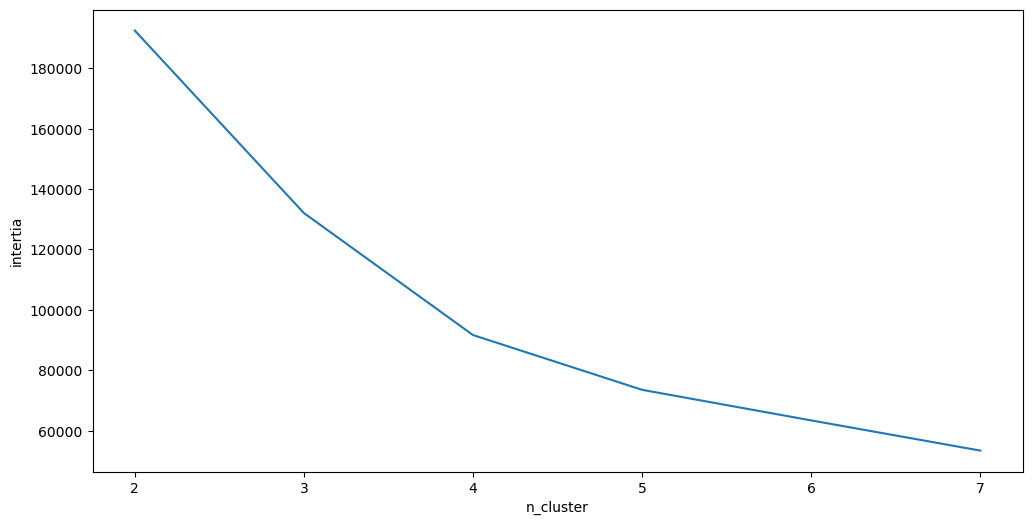

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, inertia_list)

Avec la méthode du coude, le nombre de clusters optimal (valeur de k) est de 3 ou 4.

La valeur du coefficient de silhouette permet de partager entre 3 et 4, car le coefficient de silhouette est meilleur avec 4 clusters.

A noter que le coefficient de silhouette est le plus élevé pour 2 clusters, mais 2 clusters n'apporteraient pas grand chose dans la segmentation des clients, où on aurait seulement les clients qui passent le plus de commande, et ceux qui n'en passent qu'une (voir figure plus bas).

In [17]:
# Création du DataFrame
results_df = pd.DataFrame({
    "k": k_list,  # Nombre de clusters
    "Inertia": inertia_list,
    "Silhouette": silhouette_avg_list
})

# Affichage du DataFrame
print(results_df)

   k        Inertia  Silhouette
0  2  192460.308825        0.77
1  3  132049.971076        0.32
2  4   91658.807857        0.34
3  5   73520.814947        0.33
4  6   63397.933520        0.31
5  7   53402.963338        0.33


**Visualisons le résultat du clustering avec le nombre k de clusters optimal (4) :**

In [19]:
# Appliquer le clustering avec le meilleur k (par exemple, k=3)
best_k = 4  # Remplacez par le nombre optimal de clusters choisi
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_1)

# Ajouter les labels au DataFrame X_1
X_1_with_labels = X_1.copy()
X_1_with_labels["Cluster"] = labels

# Affichage
print(X_1_with_labels.head())

    recence  frequence   montant  Cluster
0 -2.365248   5.199338  2.083949        2
1 -0.236799   5.199338  2.359068        2
2 -0.143512   5.199338  2.174590        2
3 -1.102440   5.199338  2.022140        2
4 -0.873515   5.199338  2.173204        2


In [20]:
X_1_with_labels.head(10)

,recence,frequence,montant,Cluster
0,-2.365248,5.199338,2.083949,2
1,-0.236799,5.199338,2.359068,2
2,-0.143512,5.199338,2.174590,2
3,-1.102440,5.199338,2.022140,2
4,-0.873515,5.199338,2.173204,2
5,2.658909,5.199338,-0.461957,2
6,-0.025094,5.199338,2.189446,2
7,-0.855287,5.199338,1.894471,2
8,-2.575483,5.199338,2.039686,2
9,0.011291,5.199338,1.734473,2


In [21]:
X_1_with_labels.shape

(96096, 4)

Visualisation 2D :

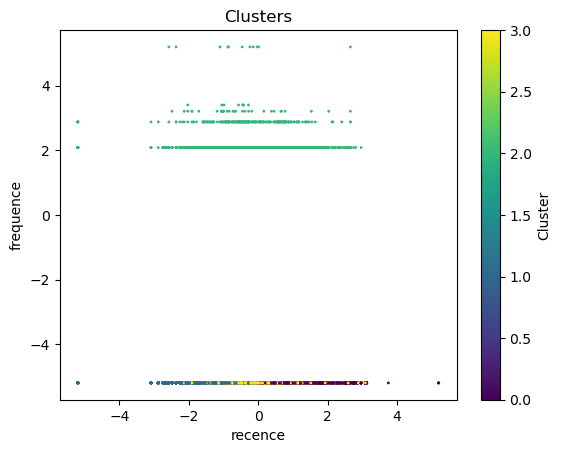

In [23]:
plt.scatter(X_1_with_labels["recence"], X_1_with_labels["frequence"], 
            c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
plt.title("Clusters")
plt.xlabel("recence")
plt.ylabel("frequence")
plt.colorbar(label="Cluster")
plt.show()

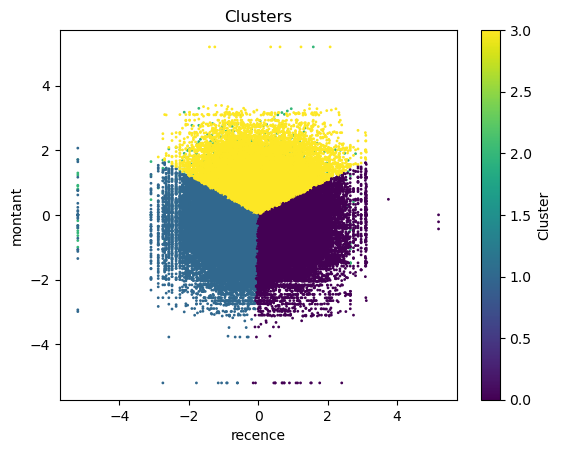

In [24]:
plt.scatter(X_1_with_labels["recence"], X_1_with_labels["montant"], 
            c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
plt.title("Clusters")
plt.xlabel("recence")
plt.ylabel("montant")
plt.colorbar(label="Cluster")
plt.show()

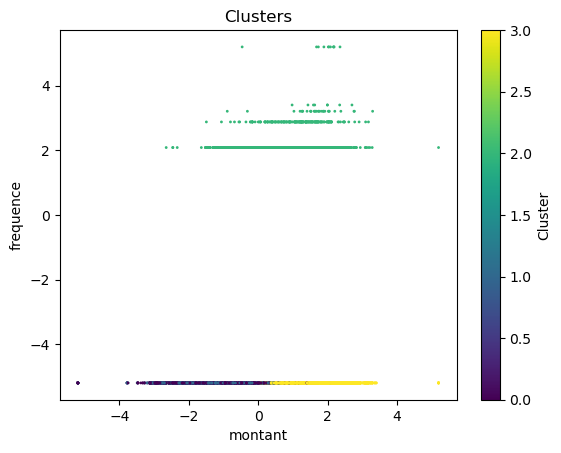

In [25]:
plt.scatter(X_1_with_labels["montant"], X_1_with_labels["frequence"], 
            c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
plt.title("Clusters")
plt.xlabel("montant")
plt.ylabel("frequence")
plt.colorbar(label="Cluster")
plt.show()

Visualisation 3D :

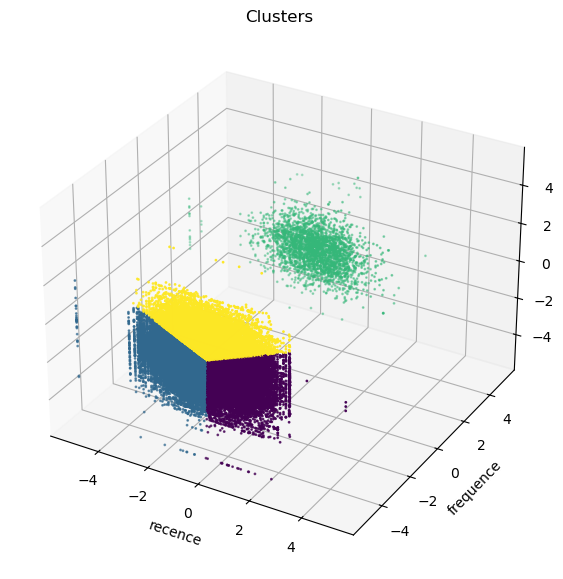

In [27]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_1_with_labels["recence"], X_1_with_labels["frequence"], X_1_with_labels["montant"], 
           c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
ax.set_title("Clusters")
ax.set_xlabel("recence")
ax.set_ylabel("frequence")
ax.set_zlabel("montant")
plt.show()

Les 4 clusters apparaissent clairement sur le schéma. La densité des clusters est correcte, mais l'écart entre les 3 clusters devant est faible.

- cluster bleu au fond (Clients fidèles) : regroupe les clients qui ont passé plusieurs commandes
- cluster jaune devant à gauche (Clients récents) : regroupe les clients qui ont passé une commande il n'y a pas longtemps.
- cluster vert devant en haut (Clients haut de gamme anciens) : regourpe les clients qui ont passé une commande il y a longtemps, et dont le montant de la commande est élevé.
- cluster violet devant en bas (Clients inactifs à faible dépense) : regroupe les clients qui ont passé une commande il y a longtemps, et dont le montant est faible

**Nombre de clients dans les 4 clusters optiamaux :**

Cluster des clients fidèles :

In [66]:
mask = X_1_with_labels['Cluster'] == 2
print("Nombre de clients fidèles (cluster vert) :", X_1_with_labels.loc[mask].shape[0])

Nombre de clients fidèles (cluster vert) : 2997


Ce nombre correspond à tous les clients qui ont fait plusieurs commandes.

Cluster des clients récents :

In [33]:
mask = X_1_with_labels['Cluster'] == 3
print("Nombre de clients récents (cluster jaune) :", X_1_with_labels.loc[mask].shape[0])

Nombre de clients récents (cluster jaune) : 29817


Cluster des clients anciens haut de gamme :

In [35]:
mask = X_1_with_labels['Cluster'] == 2
print("Nombre de clients anciens haut de gamme (cluster vert) :", X_1_with_labels.loc[mask].shape[0])

Nombre de clients anciens haut de gamme (cluster vert) : 2997


Cluster des clients inactifs à faible dépense :

In [37]:
mask = X_1_with_labels['Cluster'] == 0
print("Nombre de clients inactifs à faible dépense (cluster violet) :", X_1_with_labels.loc[mask].shape[0])

Nombre de clients inactifs à faible dépense (cluster violet) : 31916


**Visualisons le résultat du clustering avec 2 clusters :**

In [71]:
# Appliquer le clustering avec 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
labels_2 = kmeans_2.fit_predict(X_1)

# Ajouter les labels au DataFrame X_1
X_1_with_labels_2 = X_1.copy()
X_1_with_labels_2["Cluster"] = labels_2

# Affichage
print(X_1_with_labels_2.head())

    recence  frequence   montant  Cluster
0 -2.365248   5.199338  2.083949        1
1 -0.236799   5.199338  2.359068        1
2 -0.143512   5.199338  2.174590        1
3 -1.102440   5.199338  2.022140        1
4 -0.873515   5.199338  2.173204        1


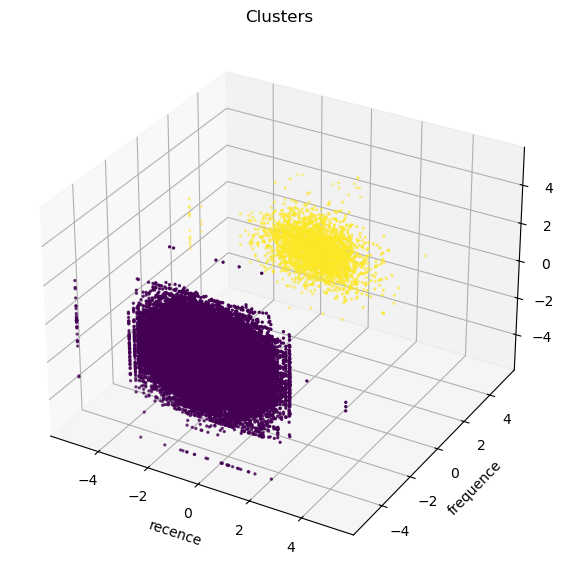

In [73]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_1_with_labels_2["recence"], X_1_with_labels_2["frequence"], X_1_with_labels_2["montant"], 
           c=X_1_with_labels_2["Cluster"], cmap="viridis", s=2)
ax.set_title("Clusters")
ax.set_xlabel("recence")
ax.set_ylabel("frequence")
ax.set_zlabel("montant")
plt.show()

On voit bien l'écart entre les 2 clusters ici : devant les clients avec une commande, derrière les clients fidèles. Mais la séparation en 2 clusters apportent peu de valeurs métiers pour une segmentation clients.